Import python packages to be used

In [1]:
import random, numpy as np, math, copy, matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
from tqdm import tqdm
from numba import njit, prange,vectorize, cuda
from numba.typed import List

Create a list of random cities to be used as the dataset for TSP

In [11]:
cities = [random.sample(range(1000), 2) for x in range(50)];

#Generate a distance matrix from the list of 50 cities
df = pd.DataFrame(cities, columns=['xcord', 'ycord'])
cities_distance_matrix = distance_matrix(df.values, df.values)

#Randomly select a city to start at for both algorithms
root = random.randint(0,49) #Randomly select one vertex as the root.

Update Methods: 

*   as_pheroupdate: Ant System Update, S*upd* <- S*iter*
*   ib_pheroupdate: Iteration Best Update, S*upd* <- arg max F(s) (to avoid premature converence, best 10(?) will be used)



In [3]:
#Ant System Update
@njit
def as_pheroupdate(pheromone_maxtix,s_iter,total_list):
   for index in range(len(total_list)):
    #print(s_iter[index])
    for jdex in range(len(s_iter[index])-1):
      x = s_iter[index][jdex]
      y = s_iter[index][jdex+1]
      pheromone_maxtix[x][y] += 1/total_list[index]

In [4]:
#Iteration Best Update
@njit
def ib_pheroupdate(pheromone_maxtix,s_iter,total_list):
  sort_index = np.argsort(np.asarray(total_list))
  #print(sort_index)
  #print(np.sort(vals))
  for index in range(10):
    for jdex in range(len(s_iter[index])-1):
      x = s_iter[sort_index[index]][jdex]
      y = s_iter[sort_index[index]][jdex+1]
      pheromone_maxtix[x][y] += 1/total_list[sort_index[index]]

Function to delete an element from a Numpy array that doesnt make Numba throw errors

In [5]:
@njit
def delete_workaround(arr, num):
    mask = np.zeros(arr.shape[0], dtype=np.int64) == 0
    mask[np.where(arr == num)[0]] = False
    return arr[mask]


Ant Colony Optimization using adjacency matrices

In [6]:
#Start of ACO algo


@njit(fastmath = True)
def aco_func(pheromone_maxtix,cities_distance_matrix,ants,alpha,beta,update_func):
  s_iter = List()
  total_list = List()
  
  for i in prange(ants):
    total = 0.0;
    currentlocation = root
    s = List()
    s.append(root)
    canVisit = np.arange(50)
    #canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation))
    canVisit = delete_workaround(canVisit, currentlocation)
    #print("start")
    while len(canVisit) !=0:
      probSum = 0
      probList = list()
      for value in canVisit:
        prob = (pheromone_maxtix[currentlocation][value] ** alpha) * ((1/cities_distance_matrix[currentlocation][value]) ** beta)
        probSum += prob
      if (probSum == 0):
        newcity = np.random.choice(canVisit)
      else:
        for value in canVisit:
          prob = ((pheromone_maxtix[currentlocation][value] ** alpha) * ((1/cities_distance_matrix[currentlocation][value]) ** beta)) / probSum
          probList.append(prob)
        cumulative_distribution = np.cumsum(np.asarray(probList))
        cumulative_distribution /= cumulative_distribution[-1]
        uniform_samples = np.random.rand(len(canVisit))
        index = np.searchsorted(cumulative_distribution, uniform_samples, side="right")
        newcity = canVisit[index[0]]
        
      #print("newcity:")
      #print(newcity)
      s.append(newcity)
      total += cities_distance_matrix[currentlocation][newcity]
      currentlocation = newcity
      canVisit =  delete_workaround(canVisit, currentlocation)

    s.append(root)
    total += cities_distance_matrix[root][currentlocation]  
    total_list.append(total)
    s_iter.append(s)

  #Pheromone Update
  update_func(pheromone_maxtix,s_iter,total_list)

Go through Adjacency matrix and return the most optimal path found.

In [43]:
def aco_results():
    currentlocation = root  #start at the randomly determined starting city
    total = 0   #counter for the total distance in the path taken
    route = []    #list to store the path taken
    canVisit = np.array(range(50))
    canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation))
    route.append(currentlocation) #append the starting position to the route

    #Each of the cities will be visited once, with the exception of the starting city, which we will return to
    for i in range(len(cities)-1):
        nextlocation = -1
        max = np.NINF
        for value in canVisit:
            if pheromone_maxtix[currentlocation][value] > max:
                max = pheromone_maxtix[currentlocation][value]
                nextlocation = value
        canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation))
        total += cities_distance_matrix[currentlocation][nextlocation] #adds the distance between the current city and the next city to the total
        route.append(nextlocation) #appends the next city to the route
        currentlocation = nextlocation #sets the current location to the next location
        canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation)) #drops the current city from the adjacency matrix since it can no longer be visited (with the exception of the return to the starting city)

    #return to the starting location at the end
    total += cities_distance_matrix[root][currentlocation] #find the distance from the last city visited to the starting location 
    route.append(root) #append the starting location to the route
    print(total)
    return route,total

Parameters for ACO

In [7]:
maxIterations = 30000
ants= 100
alpha = 1
beta = 0.8

Initialize Pheromone Matrix

In [8]:
pheromone_maxtix_50 = np.zeros(shape=(50,50))
pheromone_maxtix_25 = np.zeros(shape=(25,25))
pheromone_maxtix_10 = np.zeros(shape=(10,10))

Click to run ACO algorithm for the specified number of iterations

In [9]:
for iteration in tqdm(range(maxIterations)):
  aco_func(pheromone_maxtix,cities_distance_matrix,ants,alpha,beta,as_pheroupdate)

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [09:17<00:00, 53.83it/s]


In [41]:
pheromone_maxtix

array([[  0.        ,  59.20779971,  99.20679232, ..., 169.4534542 ,
        127.66985258,   6.85212998],
       [ 23.42248402,   0.        ,  13.63910896, ...,   1.73993575,
          4.35907197,   0.56238722],
       [188.59822444, 213.92758083,   0.        , ...,  30.9202519 ,
         13.24207857,  30.54080027],
       ...,
       [ 32.84266149,  47.48088481,  28.03812147, ...,   0.        ,
        205.66756723,   4.92048455],
       [221.88955623,  32.9245035 ,  15.60777383, ..., 131.2115021 ,
          0.        ,   4.62035457],
       [ 41.12977213,  61.46200247,  35.76676368, ...,   7.45225877,
         10.40562226,   0.        ]])

Graph Stuff

In [46]:
def sortCitiesSolution(lst):
    global cities
    x = []
    y = []
    for val in lst:
        x.append(cities[val][0])
        y.append(cities[val][1])
    return (x,y)
    

Nearest Neighbor stuff

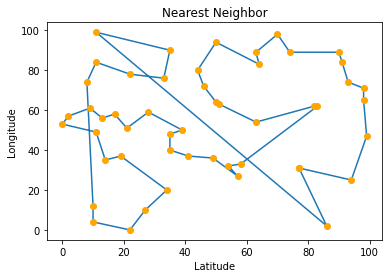

In [47]:
nearestNeighborX,nearestNeighborY = sortCitiesSolution(route)
fig,ax = plt.subplots()
plt.scatter(nearestNeighborX,nearestNeighborY ,color='orange',zorder=1)
plt.plot(nearestNeighborX,nearestNeighborY ,zorder=0)
ax.set_ylabel('Longitude')
ax.set_xlabel('Latitude')
ax.set_title('Nearest Neighbor')
#plt.set_xticks(ind)
fig.savefig("nearestneighbor.png")
plt.show()

738.233523336348


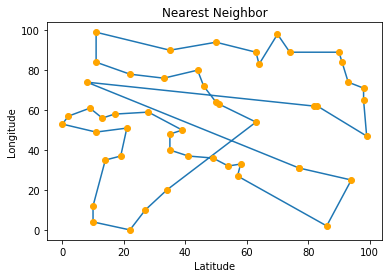

In [49]:
s_iter,total_list = aco_results()
nearestNeighborX,nearestNeighborY = sortCitiesSolution(s_iter)
fig,ax = plt.subplots()
plt.scatter(nearestNeighborX,nearestNeighborY ,color='orange',zorder=1)
plt.plot(nearestNeighborX,nearestNeighborY ,zorder=0)
ax.set_ylabel('Longitude')
ax.set_xlabel('Latitude')
ax.set_title('Nearest Neighbor')
#plt.set_xticks(ind)
fig.savefig("nearestneighbor.png")
plt.show()